In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import notebook
import lungs_finder as lf
from tqdm import notebook 
import os
import pandas as pd
import numpy as np
import cv2

# About the Dataset
CheXpert dataset was used to develop and evaluate the proposed method.
This is one of the largest and most challenging public CXR dataset currently
available, which contains 224,316 scans of unique 65,240 patients, labeled for
the presence of 14 common chest radiographic observations. Each observation
can be assigned to either positive (1), negative (0), or uncertain (-1). The main task on CheXpert is to predict the probability of multiple observations from an input CXR. The predictive models take as input a single view CXR and
output the probability of each of the 14 observations as shown in Figure 1. The
whole dataset is divided into a training set of 223,414 studies, a validation set of 200 studies, and a test set of 500 studies. For the validation set, each study is annotated by 3 board-certified radiologists and the majority vote of these annotations serves as the ground-truth label. Meanwhile, each study in the test 11 set is labeled by the consensus of 5 board-certified radiologists. The authors of CheXpert proposed an evaluation protocol over 5 observations: Atelectasis, Cardiomegaly, Consolidation, Edema, and Pleural Effusion, which were selected based on the clinical importance and prevalence from the validation set. The effectiveness of predictive models is measured by the AUC metric.

In [ ]:
#Structure of dataset folder
!tree -a -L 1  /content/CheXpert-v1.0-small


/content/CheXpert-v1.0-small
├── train
├── train.csv
├── valid
└── valid.csv

2 directories, 2 files


In [8]:
train_data=pd.read_csv('train.csv')
train_data.head()


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [9]:
#the diseaes we are going to focus on
features=['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
train_data=train_data[['Path']+features]
train_data.head()

,Path,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
0,CheXpert-v1.0-small/train/patient00001/study1/...,NaN,NaN,NaN,NaN,NaN
1,CheXpert-v1.0-small/train/patient00002/study2/...,-1.0,-1.0,-1.0,-1.0,-1.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,NaN,NaN,-1.0,NaN,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,NaN,NaN,-1.0,NaN,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,NaN,1.0,NaN,NaN,NaN


# Display first 29 images of the original Dataset

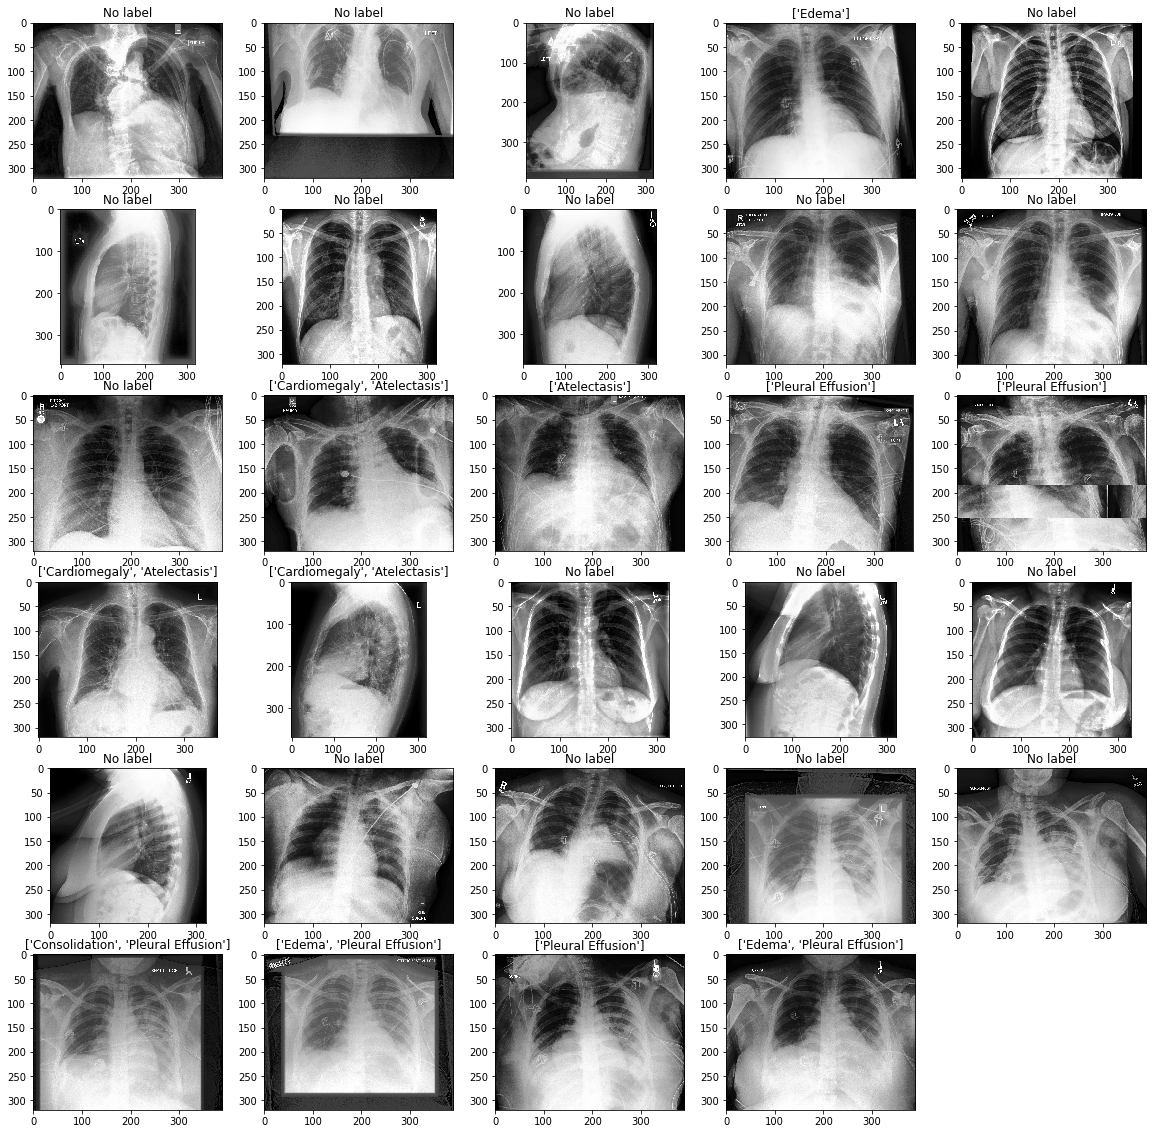

In [ ]:

def display_images(train_data):
    w=80
    h=100
    fig=plt.figure(figsize=(20,20))
    columns = 5
    rows = 6
    data=train_data.copy()
    x_train=[]
    labels=[]
    for i in range(30):
        x_train.append(data.iloc[i]['Path'])
        labels.append([feature for feature in features if data.iloc[i][feature]==1])
    #print(x_train)
    #print(labels)            
    for i in range(1, columns*rows):
        ax = fig.add_subplot(rows, columns, i)
        try:
          if len(labels[i])>0:
              ax.title.set_text(labels[i])
          else:
              ax.title.set_text('No label')
          plt.imshow(cv2.imread(x_train[i]), interpolation='nearest')
        except:
          pass      
    plt.show()
display_images(train_data)   

The images are clearly of different dimensions. We can use the train images to explore since they're already in the container. We can explore the size of majority of images

In [ ]:
data=train_data.copy()
def get_dims(file):
    img = cv2.imread(file)
    h,w = img.shape[:2]
    return h,w
dims=[]    
for i in notebook.tqdm(range(len(data))):    
    dims.append([train_data.loc[i]['Path']]+list(get_dims(data.loc[i]['Path'])))
data=pd.DataFrame(dims,columns=['Path','Height','Width'])   
data.head() 

,Path,Height,Width
0,CheXpert-v1.0-small/train/patient00001/study1/...,320,389
1,CheXpert-v1.0-small/train/patient00002/study2/...,320,390
2,CheXpert-v1.0-small/train/patient00002/study1/...,320,390
3,CheXpert-v1.0-small/train/patient00002/study1/...,390,320
4,CheXpert-v1.0-small/train/patient00003/study1/...,320,390


Grouping the images by size

In [ ]:
sizes = data.groupby(['Height', 'Width']).size().reset_index().rename(columns={0:'count'})
sizes.head()


,Height,Width,count
0,320,320,21792
1,320,321,512
2,320,322,276
3,320,323,236
4,320,324,198


## Plotting the size distribution of Images

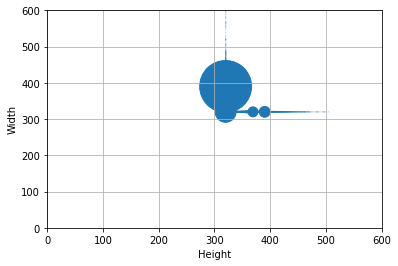

In [ ]:
sizes.plot.scatter(x='Height',y='Width',s=sizes['count']/50 ,xlim=(0,600), ylim=(0,600), grid=True)

## Distribution of images according to labels and diseases

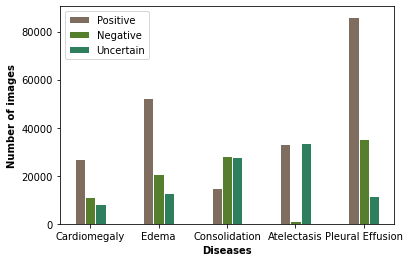

In [ ]:
barWidth = 0.15
bars1=[len(train_data[train_data[feature]==1]) for feature in features]
bars2=[len(train_data[train_data[feature]==0]) for feature in features]
bars3=[len(train_data[train_data[feature]==-1]) for feature in features]
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Positive')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Negative')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Uncertain')
 
# Add xticks on the middle of the group bars
plt.xlabel('Diseases', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], features)
plt.ylabel('Number of images', fontweight='bold') 
# Create legend & Show graphic
plt.legend()
plt.show()
 


In [ ]:
feature_with_na=[]
for feature in features[1:]:
  if train_data[feature].isna().sum()>1:
    feature_with_na.append(feature)
for feature in feature_with_na:
  
  print(feature+" has "+str(np.round(train_data[feature].isna().mean()*100,4))+"% null values")   

Edema has 61.5261% null values
Consolidation has 68.3896% null values
Atelectasis has 69.3649% null values
Pleural Effusion has 40.3748% null values


In [ ]:

pd.DataFrame({'Disease':features[1:],'Percentage of null values':[np.round(train_data[feature].isna().mean()*100,4) for feature in features[1:]]})

,Disease,Percentage of null values
0,Edema,61.5261
1,Consolidation,68.3896
2,Atelectasis,69.3649
3,Pleural Effusion,40.3748


# Data Cleaning
The learning performance of deep neural networks on raw CXRs may be
affected by the irrelevant noisy areas such as texts or the existence of irregular borders. Moreover, we observe a high ratio of CXRs that have poor alignment. we need to select only the useful part i.e. the part containing lungs. For that we will use lung finder which is a library for detecting lungs on chest x-ray images for further processing. These images are then stored in a new directory with new paths



In [ ]:
count=0
df=pd.read_csv('/content/CheXpert-v1.0-small/train.csv')
os.mkdir('Chexperttraining')
data=df['Path']
for patients in notebook.tqdm(data.values):
    image = cv2.imread(patients,0)
    
    #image=np.resize(image,(224,224))
    dest='/content/Chexperttraining/'+patients.replace('/','')
    # Get both lungs image. It uses HOG as main method,
    # but if HOG found nothing it uses HAAR or LBP.
    found_lungs = lf.get_lungs(image)
    #found_lungs=np.resize(found_lungs,(224,224))
    if found_lungs is not None:
        try:
            cv2.imwrite(dest, found_lungs)
        except:
            cv2.imwrite(dest, image)  
        count=count+1
    else:
        cv2.imwrite(dest, image)
        count=count+1

## Displaying first 29 images of the Dataset after removing the redundant parts

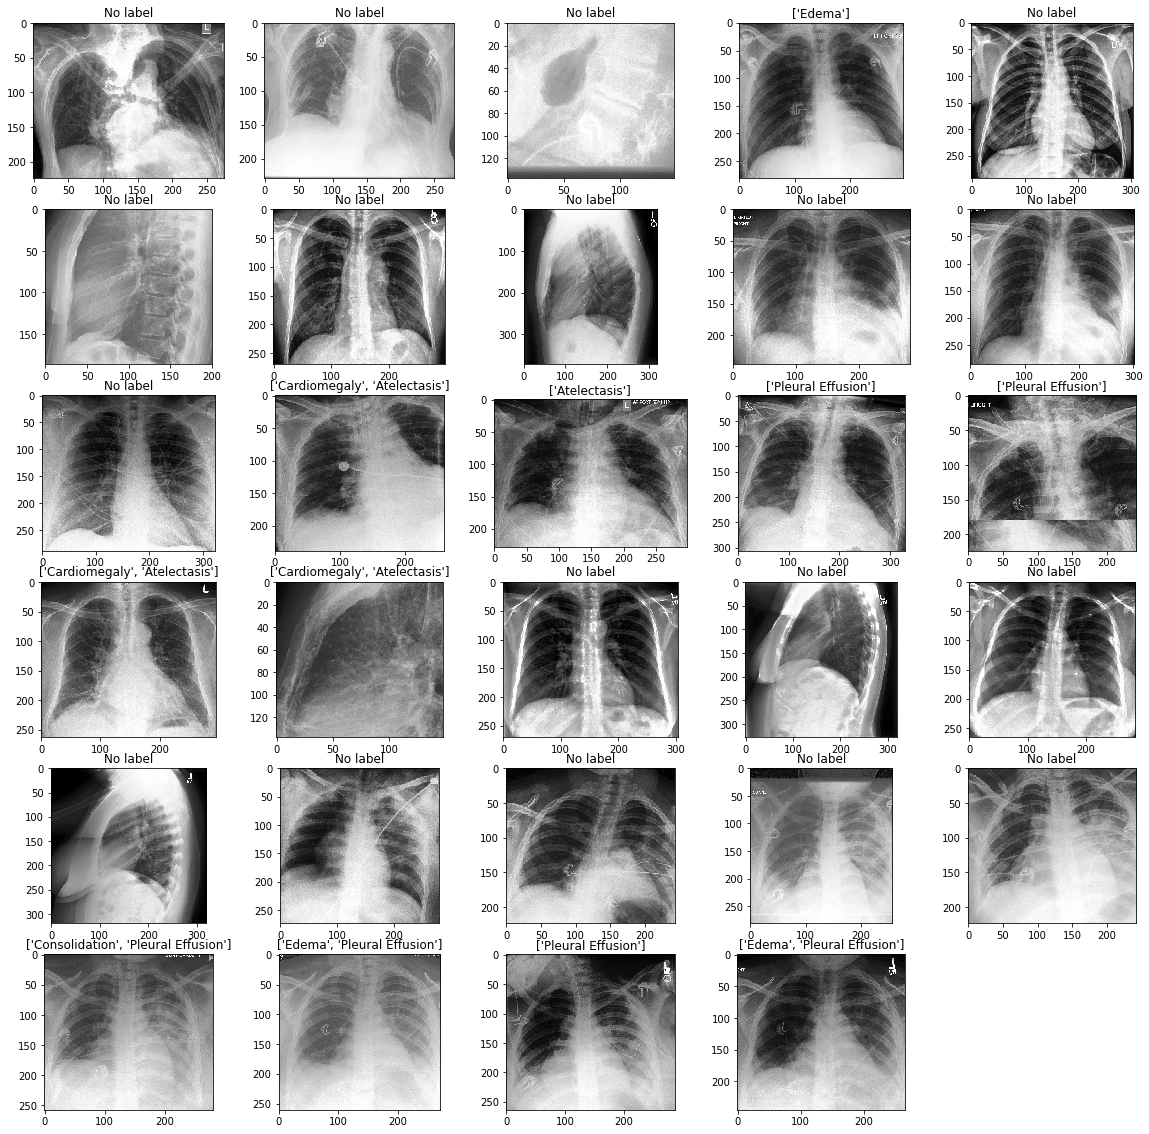

In [ ]:
#Replacing the original path with new paths and displaying the new images
data=train_data.copy()
data['Path']=data['Path'].apply(lambda element:'/content/Chexperttraining1/'+element.replace('/',''))
display_images(data)   

# Handling the uncertain values
The training labels in the dataset for each observation are either 0 (negative), 1 (positive), or u (uncertain). The author of the dataset has suggested few ways to deal with the uncertain data these are :


1.   U-Ignore: We ignore the uncertain labels during training.
2.   U-Zeroes: We map all instances of the uncertain label to 0.
1.   U-Ones: We map all instances of the uncertain label to 1.

We have applied a new advance in machine learning
called label smoothing regularization (LSR).Label smoothing is a regularization technique that perturbates the target variable, to make the model less certain of its predictions. It is viewed as a regularization technique because it restrains the largest logits fed into the sigmoid function from becoming much bigger than the rest.
So we will be using U-ones+LSR this means instad of mapping the uncertain labels to one we will map them to a value close to one we will select a value randomly between 0.55-0.85 . Similarly we have used U-zeros+LSR where we will map the uncertain valoes to a number randomly between 0-0.3





## U-Ones+LSR

In [10]:
import random
data=train_data.copy()
data=data.fillna(0)
#new path
data['Path']=data['Path'].apply(lambda element:'/content/Chexperttraining1/'+element.replace('/',''))
for disease in data.columns[1:]:
    data[disease]=data[disease].apply(lambda element: random.uniform(0.55,0.850) if element==-1 else element)
data.to_csv(r'Processed_train_LSR-Ones.csv', index = False)    

In [11]:
data.head()

,Path,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
0,/content/Chexperttraining1/CheXpert-v1.0-small...,0.000000,0.000000,0.000000,0.000000,0.000000
1,/content/Chexperttraining1/CheXpert-v1.0-small...,0.797126,0.738236,0.726169,0.569678,0.772134
2,/content/Chexperttraining1/CheXpert-v1.0-small...,0.000000,0.000000,0.556269,0.000000,0.000000
3,/content/Chexperttraining1/CheXpert-v1.0-small...,0.000000,0.000000,0.827436,0.000000,0.000000
4,/content/Chexperttraining1/CheXpert-v1.0-small...,0.000000,1.000000,0.000000,0.000000,0.000000


## U-Zeros+LSR

In [12]:
import random
data=train_data.copy()
data=data.fillna(0)
#new path
data['Path']=data['Path'].apply(lambda element:'/content/Chexperttraining1/'+element.replace('/',''))
for disease in data.columns[1:]:
    data[disease]=data[disease].apply(lambda element: random.uniform(0.0,0.3) if element==-1 else element)
data.to_csv(r'Processed_train_LSR-Zeros.csv', index = False)    

In [13]:
data.head()

,Path,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
0,/content/Chexperttraining1/CheXpert-v1.0-small...,0.00000,0.000000,0.000000,0.000000,0.000000
1,/content/Chexperttraining1/CheXpert-v1.0-small...,0.07944,0.207771,0.236403,0.194064,0.036527
2,/content/Chexperttraining1/CheXpert-v1.0-small...,0.00000,0.000000,0.025304,0.000000,0.000000
3,/content/Chexperttraining1/CheXpert-v1.0-small...,0.00000,0.000000,0.206002,0.000000,0.000000
4,/content/Chexperttraining1/CheXpert-v1.0-small...,0.00000,1.000000,0.000000,0.000000,0.000000
